# Single-Label, Multi-Class Classification with Keras

If you need to classify data into a large number of categories, it is usually a good idea to avoid creating 'information bottlenecks' in your network by using intermediate hidden layers that are significantly smaller than the number of categories.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from keras import models
from keras import layers
from keras.datasets import reuters
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


## Create and inspect training/testing data

Each sample is a list of word indexes as integers. 

In [2]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
print(len(train_data), len(test_data))
train_data[10]

2007040/2110848 [===========================>..] - ETA: 0s8982 2246


[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

## Decode word indices to words

Indices are offset by 3

In [9]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ''.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])

In [10]:
decoded_newswire

'???saidasaresultofitsdecemberacquisitionofspacecoitexpectsearningspersharein1987of115to130dlrspershareupfrom70ctsin1986thecompanysaidpretaxnetshouldrisetonineto10mlndlrsfromsixmlndlrsin1986andrentaloperationrevenuesto19to22mlndlrsfrom125mlndlrsitsaidcashflowpersharethisyearshouldbe250tothreedlrsreuter3'

In [11]:
train_labels[0]

3

## Data preparation

### Vectorize training and testing data

In [15]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

### One-hot encode labels

#### Custom one-hot function

In [17]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)
one_hot_test_labels

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

#### Using keras functions

In [18]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)
one_hot_test_labels

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Build and compile network

Dimensionality of the output space consists of 46 possible topics: use 46-way softmax as the output layer. 

In [21]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Train and validate model

In [22]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s - loss: 2.5977 - acc: 0.5306 - val_loss: 1.6702 - val_acc: 0.6390
Epoch 2/20
7982/7982 [==============================] - 1s - loss: 1.3900 - acc: 0.7062 - val_loss: 1.2789 - val_acc: 0.7170
Epoch 3/20
7982/7982 [==============================] - 1s - loss: 1.0491 - acc: 0.7701 - val_loss: 1.1157 - val_acc: 0.7560
Epoch 4/20
7982/7982 [==============================] - 1s - loss: 0.8236 - acc: 0.8231 - val_loss: 1.0159 - val_acc: 0.7900
Epoch 5/20
7982/7982 [==============================] - 1s - loss: 0.6589 - acc: 0.8628 - val_loss: 0.9655 - val_acc: 0.7970
Epoch 6/20
7982/7982 [==============================] - 1s - loss: 0.5265 - acc: 0.8930 - val_loss: 0.9172 - val_acc: 0.81400.
Epoch 7/20
7982/7982 [==============================] - 1s - loss: 0.4262 - acc: 0.9116 - val_loss: 0.9169 - val_acc: 0.8100
Epoch 8/20
7982/7982 [==============================] - 1s - loss: 0.3446 -

## Plot training and validation loss and accuracy

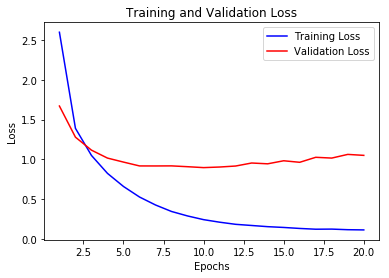

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

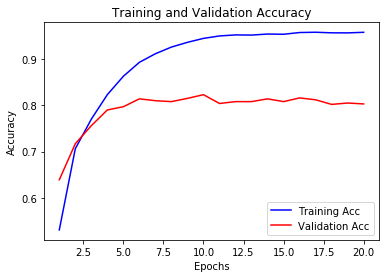

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Retrain on optimal number of epochs

In [26]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

results

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s - loss: 2.5401 - acc: 0.5226 - val_loss: 1.6792 - val_acc: 0.6540
Epoch 2/9
7982/7982 [==============================] - 0s - loss: 1.3784 - acc: 0.7098 - val_loss: 1.2821 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 0s - loss: 1.0214 - acc: 0.7786 - val_loss: 1.1343 - val_acc: 0.7520
Epoch 4/9
7982/7982 [==============================] - 0s - loss: 0.8024 - acc: 0.8249 - val_loss: 1.0551 - val_acc: 0.7570
Epoch 5/9
7982/7982 [==============================] - 0s - loss: 0.6422 - acc: 0.8623 - val_loss: 0.9761 - val_acc: 0.7960
Epoch 6/9
7982/7982 [==============================] - 0s - loss: 0.5138 - acc: 0.8918 - val_loss: 0.9120 - val_acc: 0.8100
Epoch 7/9
7982/7982 [==============================] - 0s - loss: 0.4133 - acc: 0.9143 - val_loss: 0.8928 - val_acc: 0.8230
Epoch 8/9
7982/7982 [==============================] - 0s - loss: 0.3364 - acc: 0.92

[1.0223539748153618, 0.77604630459448321]

## Accuracy of a random baseline

In [27]:
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy)))/len(test_labels)

0.182546749777382

## Generate predictions on new data

In [28]:
predictions = model.predict(x_test)
print('Shape of a single prediction: ', predictions[0].shape)
print('Sum of class probabilities: ', np.sum(predictions[0]))
print('Predicted class: ', np.argmax(predictions[0]))

Shape of a single prediction:  (46,)
Sum of class probabilities:  1.0
Predicted class:  3
